# Lecture 2.3: Resistor-Inductor-Capacitor (RLC) Circuits

An RLC circuit is a type of electric circuit that consists of resistors (R), capacitors (C), and inductors (L) or coils. These elements can be combined to form four types of circuits: RC, RL, LC, and RLC circuits. The abbreviations indicate which components are used.

The major difference between RC and RL circuits is the way they store energy. An RC circuit stores energy in the form of an electric field, while an RL circuit stores energy in the form of a magnetic field. This difference affects how the circuit behaves. In an RC circuit, the capacitor initially offers zero resistance to the current flowing through it and infinite resistance when the capacitor is fully charged. On the other hand, in an RL circuit, the coil initially opposes the current flowing through it but offers zero resistance to the current across the coil once the steady state is reached.

In this lecture, we will focus on a specific RC circuit connected to an ideal voltage source $\mathcal{E}$ that provides a constant voltage $V_\mathcal{E}$. The circuit consists of two resistors $R_1$ and $R_2$, a capacitor $C$, and a switch $S$. The figure below shows the circuit diagram.

<img src="images/rc-circuit.png" alt="RC Circuit" width="25%"/>

### A little bit of theory to solve RC Circuits

To better understand the math to solve an electric circuit, we will first review some basic concepts of electric circuits.

- A fundamental equation in electric circuits is the **Ohm's law**. It states that the current $j$ flowing through a resistor is proportional to the voltage $V$ across the resistor $R$,
    $$
    j = \frac{V}{R}.
    $$

- A **capacitor** consists of two isolated conductors (the plates) with charges $+q$ and $-q$.
    Its capacitance C is defined from
    $$
    V_C = \frac{q_C}{C} = \frac{1}{C} \int j_C(t) dt
    \quad \iff \quad
    j_C(t) = \frac{dq_C(t)}{dt} ,
    $$
    where $V_C$ is the potential difference between the plates, $q_C$ is the charge on the capacitor, and $j_C$ is the current flowing through the capacitor.

<!-- - The general formula for the **voltage across a capacitor** is given by
    $$
    V_C(t) = V_C(t\to\infty) + \left[V_C(t = t_0) - V_C(t\to\infty)\right] e^{(t_0 - t)/\tau}
    $$
    where $V_C(t=t_0)$ is the initial voltage across the capacitor and $V_C(t\to\infty)$ is the voltage across the capacitor when the capacitor is fully charged. The time constant $\tau = R_{eq} C$ is a measure of how quickly the capacitor charges up. -->

- Finally, we state the **Kirchhoff's laws** - Kirchoff Voltage Law (KVL) and Kirchoff Current Law (KCL) - to find the current $j(t)$ flowing through the circuit. 
1. KVL or loop rule states that the sum of the voltage drops around a closed loop is equal to the sum of the voltage rises around the loop,
    $$
    V_\mathcal{E} = \sum V_i.
    $$
2. KCL or junction rule states that the sum of the currents entering a node is equal to the sum of the currents leaving the node,
    $$
    \sum j_i = 0.
    $$

### The Simulation

Our studied example will simulate a case where the switch $S$ is suddenly closed (at $t = 0$) and then after a time interval (at $t = t_S$) it is opened again.

### Importing the required libraries

In [1]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
from SALib import ProblemSpec
import numpy as np
import matplotlib.pyplot as plt

# set font as Stix 
plt.rcParams["mathtext.fontset"] = "stix"

Next we will define our function to model the studied circuit. 

Our function receives as input: the resistance values $R_1$ and $R_2$, the capacitance $C$, the voltage source $V_\mathcal{E}$, the initial and final time $t_0$ and $t_f$, and a

The function returns: the currents and voltages $j_C(t)$, $j_1(t)$, $j_2(t)$, $V_C(t)$, $V_1(t)$, and $V_2(t)$ observed through the capacitor $C$, resistor $R_1$ and resistor $R_2$, respectively.

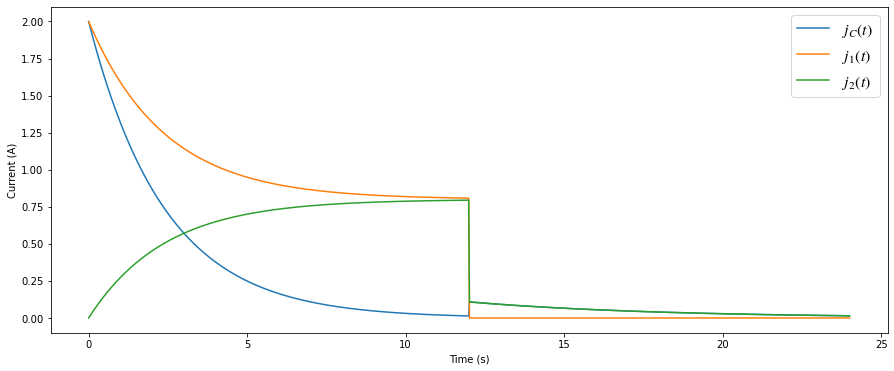

In [19]:
def circuit_simulation(R1, R2, C, Ve, t0, tS, tf, n_steps=1000):

    # Time vector
    t = np.linspace(t0, tf, n_steps)

    # closed switch / charging capacitor
    alpha = R1/R2 + 1
    jC = np.exp( -alpha*t/(R1*C) ) * Ve / R1
    j2 = (1 - np.exp( -alpha*t/(R1*C) ) ) * Ve / (R1+R2)
    j1 = j2 + jC

    # integrate jC to get qC
    q0 = np.trapz(jC, t)
    Vc = q0/C

    # open switch / discharging capacitor
    j1[t > tS] = 0
    jC[t > tS] = q0/(R2*C) * np.exp( -t[t > tS]/(R2*C) )
    j2[t > tS] = jC[t > tS]

    return t, jC, j1, j2
    
# test the function
t, iC, i1, i2 = circuit_simulation(10, 15, 0.4, 20, 0, 12, 24)

plt.figure(figsize=(15, 6))
plt.plot(t, iC, label='$j_C(t)$')
plt.plot(t, i1, label='$j_1(t)$')
plt.plot(t, i2, label='$j_2(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend(fontsize=16)
plt.show()

Now, let's define our wrapped function to work with the sensitivity analysis.

In [24]:
def wrapped_circuit(rv_params, t0, tS, tf, n_steps=100):

    currents = np.zeros((rv_params.shape[0], n_steps, 3))
    for i, (R1, R2, C, Ve) in enumerate(rv_params):
        _, currents[i, :, 0], currents[i, :, 1], currents[i, :, 2] = circuit_simulation(R1, R2, C, Ve, t0, tS, tf, n_steps=n_steps)
        
    # reshape to (n_samples, n_steps * n_dim)
    currents = currents.reshape((rv_params.shape[0], -1))

    return currents

## Sensitivity Analysis

### Defining the Analysis Problem

For this problem we gonna analyze the sensitivity of diferent quantities of interest (QoI) with respect to the resistance values $R_1$ and $R_2$, the capacitance $C$ and the voltage source $V_\mathcal{E}$. The QoIs are the currents $j_C(t)$, $j_1(t)$, $j_2(t)$ observed through the capacitor $C$, resistor $R_1$ and resistor $R_2$, respectively.

In [30]:
# defining colors and latex symbols for plotting
colors = ['red', 'blue', 'green', 'purple']
latex_symbols = {   'R1': r'R_1',
                    'R2': r'R_2',
                    'C': r'C',
                    'Ve': r'V_\mathcal{E}'
                }

In [25]:
t0, tS, tf = 0, 12, 24
n_steps = 100

alpha = 0.05
problem = {
    'num_vars': 4,
    'names': ['R1', 'R2', 'C', 'Ve'],
    'bounds': [[5, 15], [10, 20], [0.2, 0.6], [15, 25]]
}

sp = ProblemSpec(problem)

n_samples = 2**10
sp.sample_sobol(n_samples) \
    .evaluate( lambda rv_params: wrapped_circuit(rv_params, t0, tS, tf, n_steps) ) \
    .analyze_sobol()

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])

evaluations = sp.results

c:\Users\Lamap\anaconda3\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


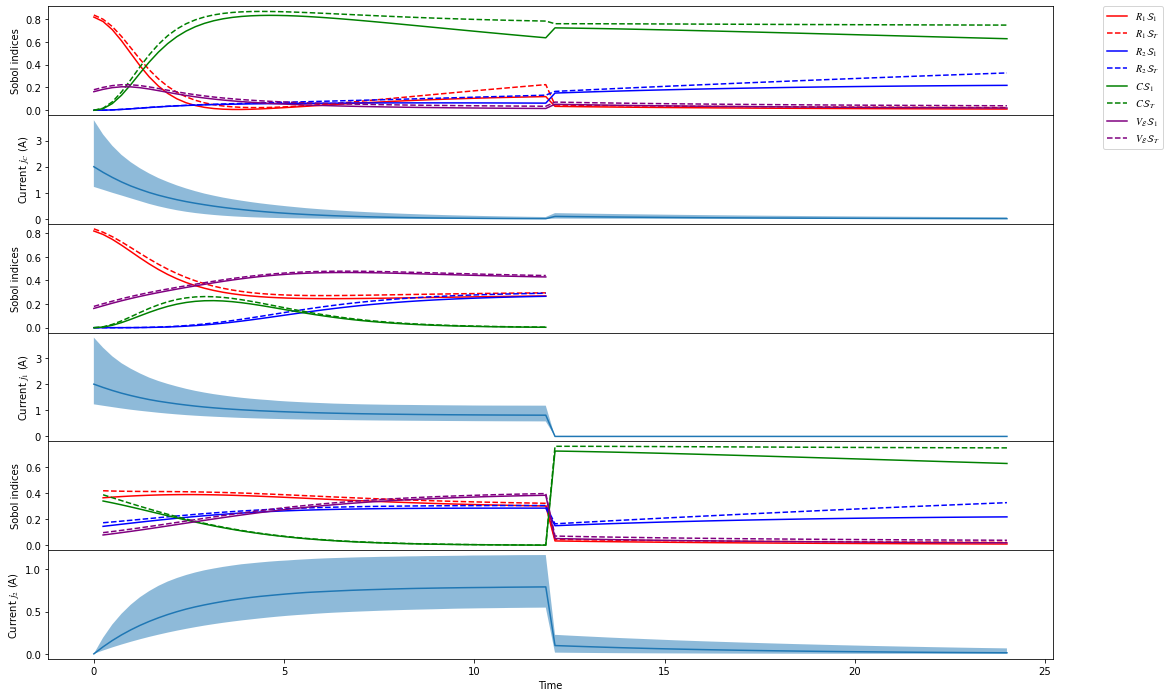

In [31]:
t = np.linspace(t0, tf, n_steps)

# reshape back to (n_samples, n_steps, n_curr)
evaluations = evaluations.reshape((-1, t.shape[0], 3))
S1s = S1s.reshape((t.shape[0], 3, 4))
STs = STs.reshape((t.shape[0], 3, 4))

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(18, 12))
for curr in range(3):
    for i, key in enumerate(problem['names']):
        ax[2*curr].plot(t, S1s[:,curr,i], label=rf'${latex_symbols[key]}\, \mathcal{{S}}_1$', color=colors[i])
        ax[2*curr].plot(t, STs[:,curr,i], '--', label=rf'${latex_symbols[key]}\, \mathcal{{S}}_T$', color=colors[i])
    ax[2*curr].set_ylabel('Sobol indices')
    # ax[2*curr].legend()

    median = np.median(   evaluations[:,:,curr], axis=0)
    upper = np.percentile(evaluations[:,:,curr], 95, axis=0)
    lower = np.percentile(evaluations[:,:,curr], 5, axis=0)
    ax[2*curr+1].plot(t, median, label='median')
    ax[2*curr+1].fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
    ax[2*curr+1].set_xlabel('Time')
    ax[2*curr+1].set_ylabel(rf'Current $j_{curr if curr>=1 else "C"}$ (A)')

# put the legend outside the plot
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Conclusions

Note that as the switch opens and there is no current in the left section of the circuit, the sensitivity response for the current $j_1(t)$ - associated with the resistor $R_1$ - is impossible to be computed.

For the first QoI, the current $j_C(t)$, the highest dependence at the beggining of the charging relies on the resistance $R_1$ as it is the only resistor in series for the capacitor $C$. After some time, the dependence of the current $j_C(t)$ with respect to the capacitance $C$ becomes more significant as the charge of the capacitor $C$ increases. Finally, after the switch opens, $C$ rules the sensitivity and the resistance $R_2$ becomes more important as they are the only components in the circuit closed.

    Critical reasoning about the other two QoIs will be left as an exercise for the reader.

___
### References

[1] Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D., Saisana, M., Tarantola, S., (2008). Global Sensitivity Analysis: The Primer. John Wiley & Sons, Ltd, Chichester, UK.

[2] Walker, J., Resnick, R., & Halliday, D. (2022). Fundamentals of Physics. Wiley. John Wiley & Sons.